In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy
import itertools

# 1d

## логика

In [3]:
def swap_halves(a):
    n = len(a)
    assert n % 2 == 0
    
    m = n // 2
    
    b = a
    b = np.r_[
        b[m:],
        b[:m],
    ]
    
    return b

def left_right_pad(a, m):
    n = len(a)
    
    assert n % 2 == 0
    assert m % 2 == 0
    assert m >= n
    
    l = (m - n) // 2
    r = l + n
    
    b = np.zeros(m, dtype=a.dtype)
    b[l:r] = a
    
    return b

def left_right_unpad(b, n):
    m = len(b)
    
    assert n % 2 == 0
    assert m % 2 == 0
    assert m >= n
    
    l = (m - n) // 2
    r = l + n
    
    return b[l:r]

def ascomplex(a):
    return np.array(a, dtype=np.complex)

In [4]:
def finite_fft(n, a_f, step_f, ys_f_shifted, m):
    assert n % 2 == 0
    assert m % 2 == 0

    fft_arg = ys_f_shifted
    fft_arg = left_right_pad(fft_arg, m)
    fft_arg = swap_halves(fft_arg)
    
    fft_res = np.fft.fft(fft_arg)
    
    ys_F = fft_res * step_f
    ys_F = swap_halves(ys_F)
    ys_F = left_right_unpad(ys_F, n)
    
    return ys_F

In [5]:
def finite_integral(n, step_f, xs_f, ys_f, xs_F):
    # first dimension - x
    x_2d = np.broadcast_to(xs_f[:, np.newaxis], (n, n))
    
    # second dimension - u
    u_2d = np.broadcast_to(xs_F[np.newaxis, :], (n, n))
    
    # exp values
    A = np.exp((-2 * np.pi * 1j) * x_2d * u_2d)
    
    # scale rows by f(x)
    A = A * np.broadcast_to(ys_f[:, np.newaxis], (n, n))

    int_weights = np.ones(n)
    int_weights[0] = 1/2
    int_weights[-1] = 1/2
    int_weights *= step_f
    
    # scale rows by int_weights
    A = A * np.broadcast_to(int_weights[:, np.newaxis], (n, n))

    ys_F = np.sum(A, axis=0)
    
    return ys_F

In [6]:
def draw_1d(sp_n, sp_m, sp_c, xs, ys, s):
    subplot(sp_n, sp_m, sp_c + 1)
    plot(xs, np.abs(ys))
    title(f'$\\left|{s}\\right|$')

    subplot(sp_n, sp_m, sp_c + 2)
    plot(xs, np.angle(ys))
    ylim(-np.pi * 1.1, np.pi * 1.1)
    title(f'$\\angle {s}$')

    subplot(sp_n, sp_m, sp_c + 3)
    plot(xs, np.real(ys))
    title(f'$\\Re {s}$')

    subplot(sp_n, sp_m, sp_c + 4)
    plot(xs, np.imag(ys))
    title(f'$\\Im {s}$')

## примеры

In [7]:
# gauss

f = lambda x: np.exp(-x**2)
F = lambda x: np.sqrt(np.pi) * np.exp(-x**2 * np.pi**2)

n = 1 << 10
m = 1 << 15

a_f = 5

In [9]:
# var 1
f = np.sinc
F = lambda x: (np.abs(x) <= 1/2) * 1

n = 1 << 10
m = 1 << 15

a_f = 5

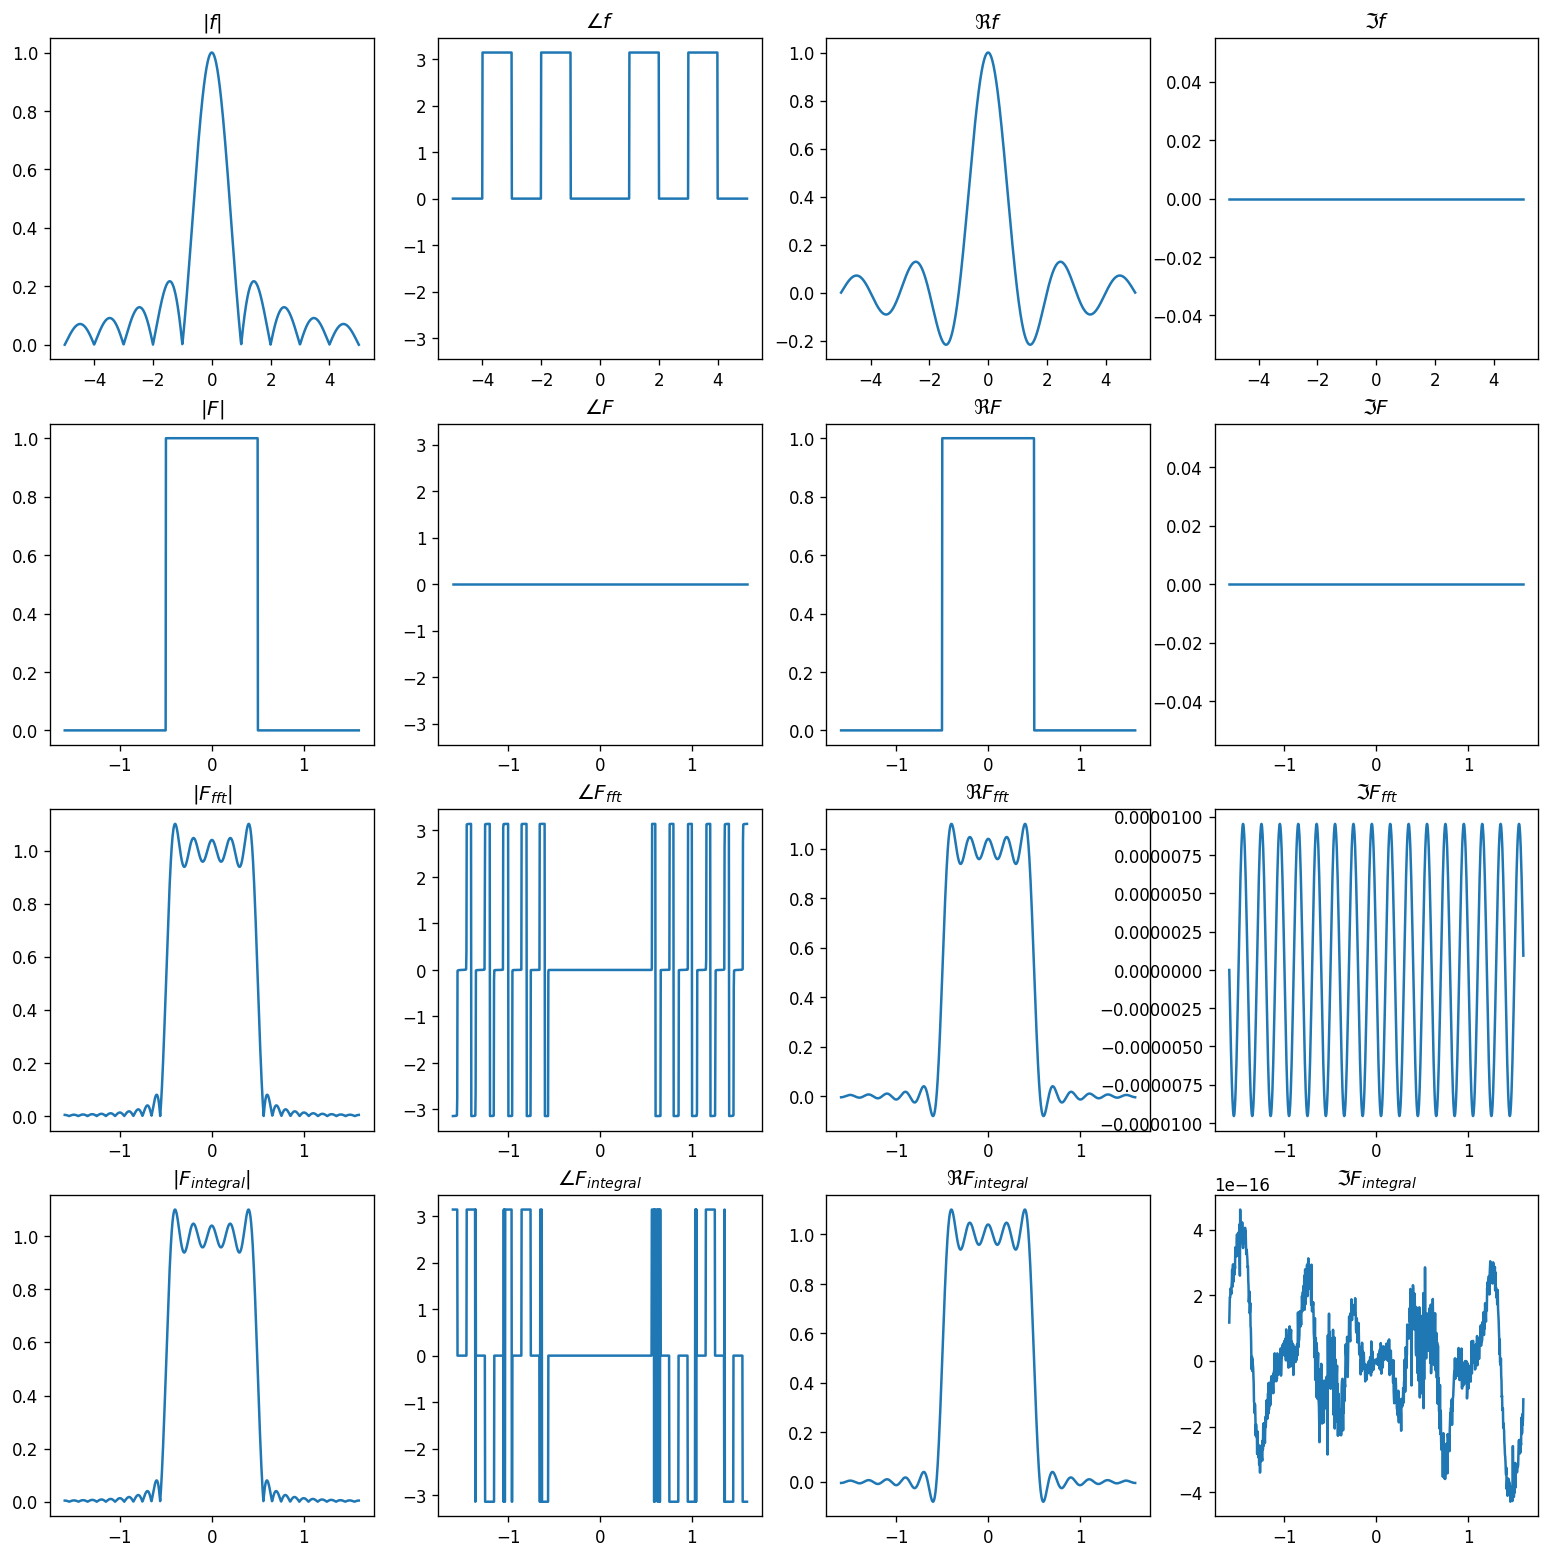

In [10]:
# prep
a_F = n ** 2 / (4 * a_f * m)

step_f = 2 * a_f / (n - 1)
step_F = 2 * a_F / (n - 1)

xs_f = np.linspace(-a_f, a_f, n)
xs_f_shifted = xs_f - step_f / 2
xs_F = np.linspace(-a_F, a_F, n)

ys_f = ascomplex(f(xs_f))
ys_f_shifted = ascomplex(f(xs_f_shifted))

# analytical
ys_F_analytical = ascomplex(F(xs_F))

# fft
ys_F_fft = ascomplex(finite_fft(n, a_f, step_f, ys_f_shifted, m))

# integral
ys_F_integral = ascomplex(finite_integral(n, step_f, xs_f, ys_f, xs_F))

figsize(16, 16)
draw_1d(4, 4, 0, xs_f, ys_f, 'f')
draw_1d(4, 4, 4, xs_F, ys_F_analytical, 'F')
draw_1d(4, 4, 8, xs_F, ys_F_fft, 'F_{fft}')
draw_1d(4, 4, 12, xs_F, ys_F_integral, 'F_{integral}')

# 2d

## логика

In [11]:
def swap_halves_2d(a):
    n = len(a)
    assert n % 2 == 0
    
    m = n // 2
    
    b = a
    b = np.r_[
        b[m:, :],
        b[:m, :],
    ]
    b = np.c_[
        b[:, m:],
        b[:, :m],
    ]
    
    return b

def left_right_pad_2d(a, m):
    n = len(a)
    
    assert n % 2 == 0
    assert m % 2 == 0
    assert m >= n
    
    l = (m - n) // 2
    r = l + n
    
    b = np.zeros((m, m), dtype=a.dtype)
    b[l:r, l:r] = a
    
    return b

def left_right_unpad_2d(b, n):
    m = len(b)
    
    assert n % 2 == 0
    assert m % 2 == 0
    assert m >= n
    
    l = (m - n) // 2
    r = l + n
    
    return b[l:r, l:r]

In [12]:
def finite_fft_2d(n, a_f, step_f, ys_f_shifted, m):
    assert n % 2 == 0
    assert m % 2 == 0

    fft_arg = ys_f_shifted
    fft_arg = left_right_pad_2d(fft_arg, m)
    fft_arg = swap_halves_2d(fft_arg)
    
    fft_res = np.fft.fft2(fft_arg)
    ys_F = fft_res * step_f ** 2
    ys_F = swap_halves_2d(ys_F)
    ys_F = left_right_unpad_2d(ys_F, n)
    
    return ys_F

In [13]:
def finite_integral_2d(n, step_f, xs_f, ys_f, xs_F):
    shape = (n, n, n, n)
    
    # first dimension - x
    x_4d = np.broadcast_to(xs_f[:, np.newaxis, np.newaxis, np.newaxis], shape)
    # second dimension - y
    y_4d = np.broadcast_to(xs_f[np.newaxis, :, np.newaxis, np.newaxis], shape)
    
    # third dimension - u
    u_4d = np.broadcast_to(xs_F[np.newaxis, np.newaxis, :, np.newaxis], shape)
    # forth dimension - v
    v_4d = np.broadcast_to(xs_F[np.newaxis, np.newaxis, np.newaxis, :], shape)
    
    # exp values
    A = np.exp((-2 * np.pi * 1j) * (x_4d * u_4d + y_4d * v_4d))
    
    # scale d1 and d2 by f(x, y)
    A = A * np.broadcast_to(ys_f[:, :, np.newaxis, np.newaxis], shape)

    int_weights = np.ones(n)
    int_weights[0] = 1/2
    int_weights[-1] = 1/2
    int_weights *= step_f
    
    # scale d1 by int_weights
    A = A * np.broadcast_to(int_weights[:, np.newaxis, np.newaxis, np.newaxis], shape)
    # scale d2 by int_weights
    A = A * np.broadcast_to(int_weights[np.newaxis, :, np.newaxis, np.newaxis], shape)

    ys_F = A
    ys_F = np.sum(ys_F, axis=0)
    ys_F = np.sum(ys_F, axis=0)
    
    return ys_F

In [14]:
def draw_2d(sp_n, sp_m, sp_c, xs, ys, s):
    extent = [xs[0], xs[-1], xs[0], xs[-1]]
    
    subplot(sp_n, sp_m, sp_c + 1)
    imshow(np.abs(ys), extent=extent)
    colorbar()
    title(f'$\\left|{s}\\right|$')

    subplot(sp_n, sp_m, sp_c + 2)
    imshow(np.angle(ys), extent=extent, vmin=-np.pi, vmax=np.pi)
    colorbar()
    title(f'$\\angle {s}$')

    subplot(sp_n, sp_m, sp_c + 3)
    imshow(np.real(ys), extent=extent)
    colorbar()
    title(f'$\\Re {s}$')

    subplot(sp_n, sp_m, sp_c + 4)
    imshow(np.imag(ys), extent=extent)
    colorbar()
    title(f'$\\Im {s}$')

## примеры

In [15]:
# gauss

n = 1 << 6
m = 1 << 8

a_f = 5

f_2d = lambda a: np.exp(-(a[:, :, 0]**2 + a[:, :, 1]**2))
F_2d = lambda a: np.pi * np.exp(-(a[:, :, 0]**2 + a[:, :, 1]**2) * np.pi**2)

In [16]:
# var 1

n = 1 << 6
m = 1 << 8

a_f = 5

f_2d = lambda a: np.sinc(a[:, :, 0]) * np.sinc(a[:, :, 1])
F_2d = lambda a: (np.abs(a[:, :, 0]) <= 1/2) * 1 * (np.abs(a[:, :, 1]) <= 1/2) * 1

In [120]:
# var 7

n = 1 << 6
m = 1 << 8

a_f = 5

f_2d = lambda a: a[:, :, 0] ** 2 * a[:, :, 1] ** 2
F_2d = lambda a: (
    (
        2 * (np.pi * a[:, :, 0] * a_f)**2 * np.sin(2 * (np.pi * a[:, :, 0] * a_f)) + 
        2 * (np.pi * a[:, :, 0] * a_f) * np.cos(2 * (np.pi * a[:, :, 0] * a_f)) - 
        np.sin(2 * (np.pi * a[:, :, 0] * a_f))
    ) / (2 * np.pi**3 * a[:, :, 0]**3)
    *
    (
        2 * (np.pi * a[:, :, 1] * a_f)**2 * np.sin(2 * (np.pi * a[:, :, 1] * a_f)) + 
        2 * (np.pi * a[:, :, 1] * a_f) * np.cos(2 * (np.pi * a[:, :, 1] * a_f)) - 
        np.sin(2 * (np.pi * a[:, :, 1] * a_f))
    ) / (2 * np.pi**3 * a[:, :, 1]**3)
)

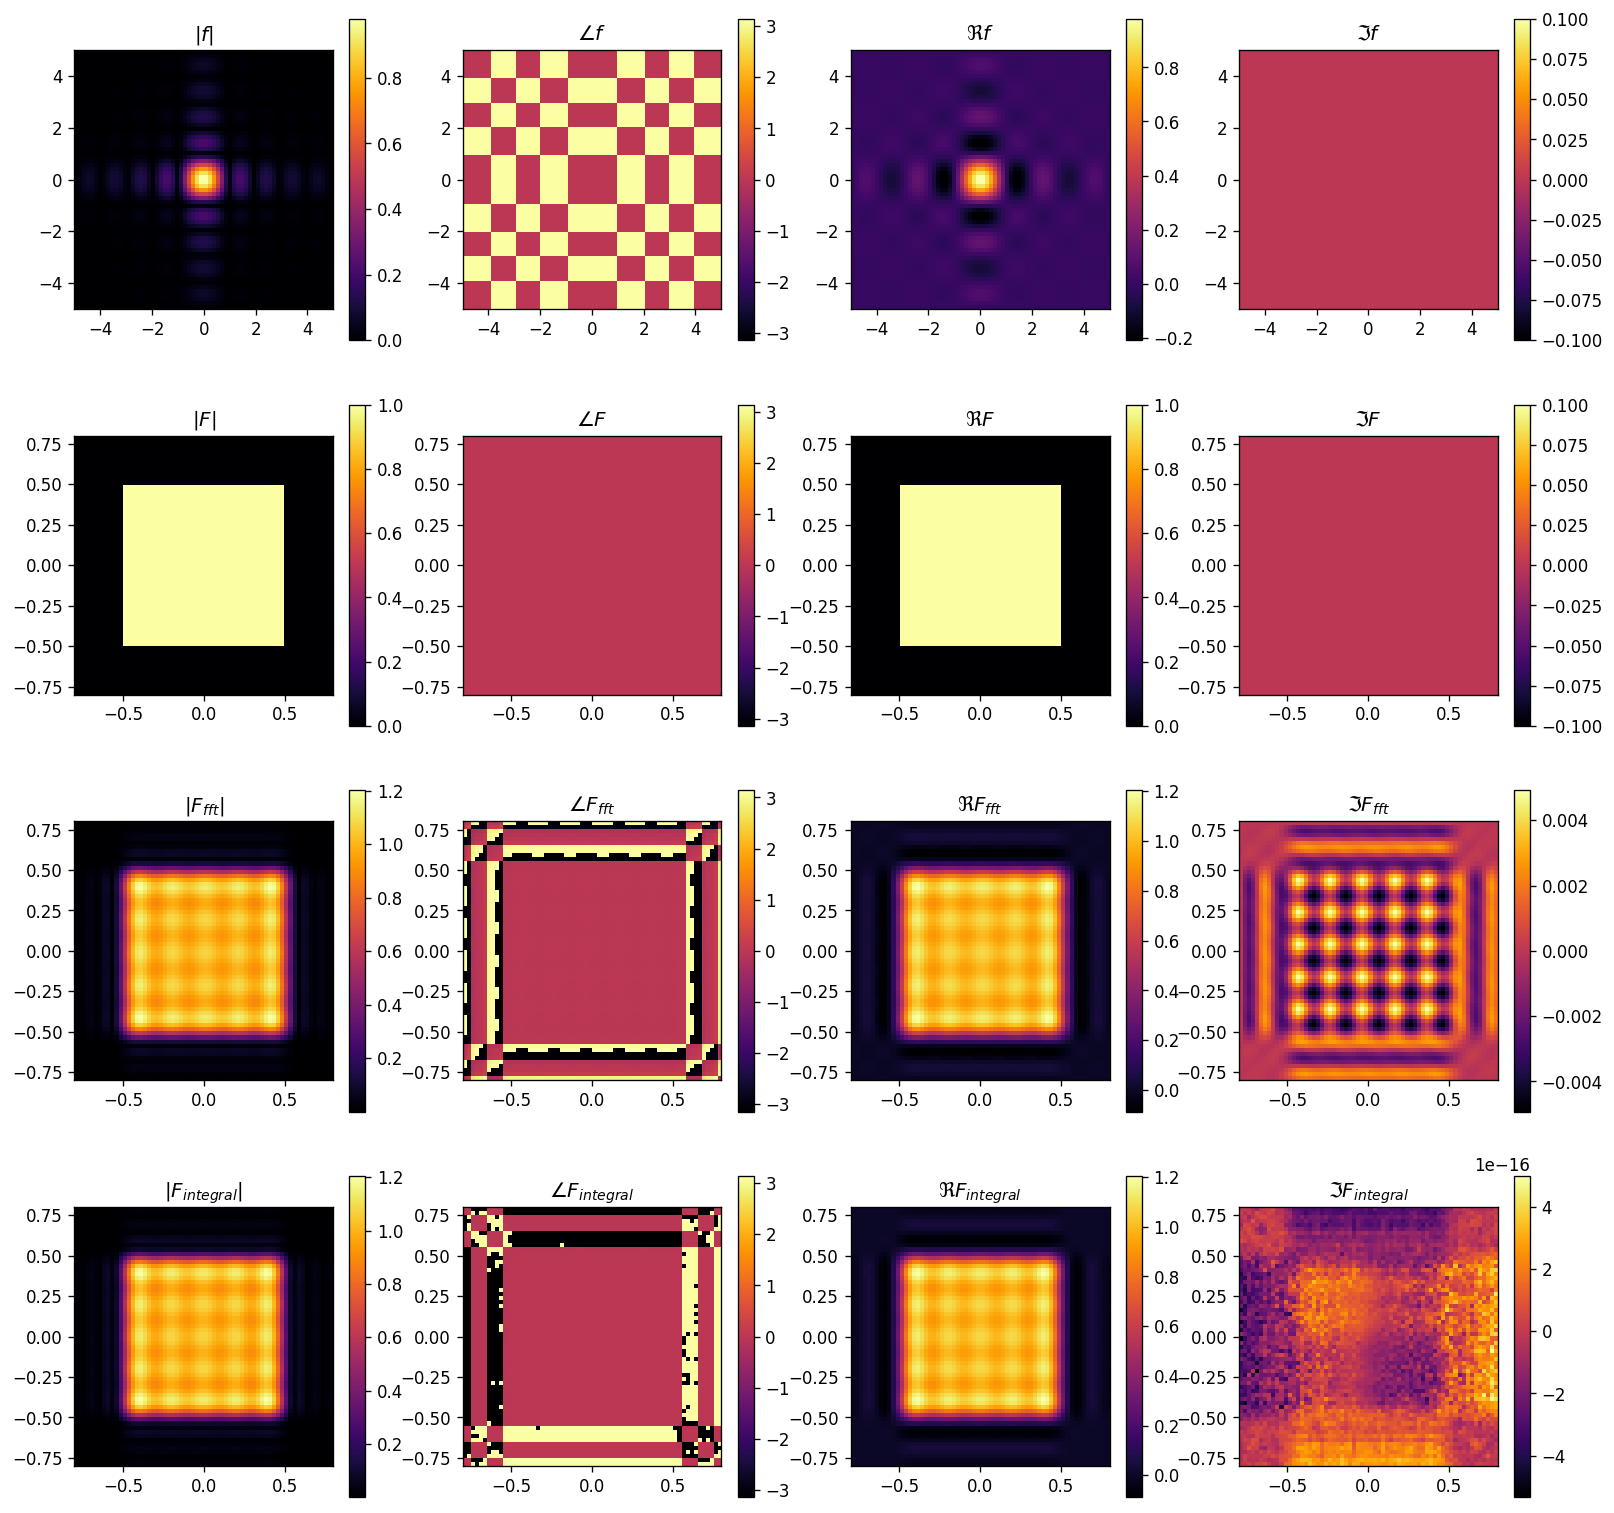

In [17]:
# prep
a_F = n ** 2 / (4 * a_f * m)

step_f = 2 * a_f / (n - 1)
step_F = 2 * a_F / (n - 1)

xs_f = np.linspace(-a_f, a_f, n)
xs_f_shifted = xs_f - step_f / 2
xs_F = np.linspace(-a_F, a_F, n)

Xs_f = np.reshape(list(itertools.product(xs_f, xs_f)), (n, n, 2))
Xs_f_shifted = np.reshape(list(itertools.product(xs_f_shifted, xs_f_shifted)), (n, n, 2))
Xs_F = np.reshape(list(itertools.product(xs_F, xs_F)), (n, n, 2))

ys_f = ascomplex(f_2d(Xs_f))
ys_f_shifted = ascomplex(f_2d(Xs_f_shifted))

# analytical
ys_F_analytical = ascomplex(F_2d(Xs_F))

# fft
ys_F_fft = ascomplex(finite_fft_2d(n, a_f, step_f, ys_f_shifted, m))

# integral
ys_F_integral = ascomplex(finite_integral_2d(n, step_f, xs_f, ys_f, xs_F))

figsize(16, 16)
draw_2d(4, 4, 0, xs_f, ys_f, 'f')
draw_2d(4, 4, 4, xs_F, ys_F_analytical, 'F')
draw_2d(4, 4, 8, xs_F, ys_F_fft, 'F_{fft}')
draw_2d(4, 4, 12, xs_F, ys_F_integral, 'F_{integral}')